# Data Cleaning Code

In [0]:
# %pip install torch===2.1.0
%pip install "boto3==1.21.32" "fsspec==2023.10.0" "s3fs==0.4.2"

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
# import sklearn
# import numpy as np
# import scipy
# import plotly
# import bs4 as bs
# import urllib.request
import boto3

In [0]:
import os 
# To work with Amazon S3 storage, set the following variables using  
# your AWS Access Key and Secret Key 
access_key = 'xxxxxxxxxxxxxxxxxxxx' 
secret_key = 'xxxxxxxxxxxxxxxxxxxx' 
# Set the environment variables so boto3 can pick them up later.  
# Do not modify the next three lines of code 
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
encoded_secret_key = secret_key.replace("/", "%2F").replace("+", "%2B") 
# Set aws_region to where your S3 bucket was created 
aws_region = "us-east-1" 
# Set to the name of your Amazon S3 bucket 
bucket_name = 'my-bigdata-project-ec' 

# Update the Spark options using the Spark context to work with AWS Credentials 
# Do not modify the next four lines 
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key) 
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key) 
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region + ".amazonaws.com") 
sc._jsc.hadoopConfiguration().set("fs.s3a.bucket."+bucket_name+".endpoint.region", aws_region) 



In [0]:
# Import all necessary PySpark Functions
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [0]:
# Read in the file into a Spark dataframe
sdf = spark.read.option("header",True).option("multiLine",True) \
    .option("escape","\"").option("inferSchema",True) \
        .option("separator",",").csv('s3a://my-bigdata-project-ec/Landing/imdb_top_1000.csv')


In [0]:
#Convert to pandas
# df= sdf.select("*").toPandas()
# df
print(f"Number of Records {sdf.count()}")
sdf.show(5)

Number of Records 1000
+--------------------+--------------------+-------------+-----------+-------+--------------------+-----------+--------------------+----------+--------------------+--------------+--------------+-------------+--------------+-----------+-----------+
|         Poster_Link|        Series_Title|Released_Year|Certificate|Runtime|               Genre|IMDB_Rating|            Overview|Meta_score|            Director|         Star1|         Star2|        Star3|         Star4|No_of_Votes|      Gross|
+--------------------+--------------------+-------------+-----------+-------+--------------------+-----------+--------------------+----------+--------------------+--------------+--------------+-------------+--------------+-----------+-----------+
|https://m.media-a...|The Shawshank Red...|         1994|          A|142 min|               Drama|        9.3|Two imprisoned me...|        80|      Frank Darabont|   Tim Robbins|Morgan Freeman|   Bob Gunton|William Sadler|    2343110| 2

In [0]:
# Some select statements for debugging.
sdf.select("Poster_Link").show(100)
sdf.select("Released_Year").show(500)
sdf.select("Certificate").show(500)
sdf.select("Runtime").show(750)
sdf.select("Genre").show(750, truncate=False)
sdf.select("IMDB_Rating").show(750, truncate=False)
sdf.select("Overview").show(750, truncate=False)
sdf.select("Meta_Score").show(750, truncate=False)
sdf.select("Star1").show(750, truncate=False)


+--------------------+
|         Poster_Link|
+--------------------+
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.media-a...|
|https://m.

In [0]:
# Get some statistics on each of the columns (Warning: This can take a long time)
sdf.select("Released_Year","Runtime","IMDB_Rating","Meta_score","Star1","Star2","Star3","Star4","No_of_Votes","Gross").summary().show()


+-------+------------------+-------+------------------+------------------+----------------+------------+-----------+------------+------------------+---------+
|summary|     Released_Year|Runtime|       IMDB_Rating|        Meta_score|           Star1|       Star2|      Star3|       Star4|       No_of_Votes|    Gross|
+-------+------------------+-------+------------------+------------------+----------------+------------+-----------+------------+------------------+---------+
|  count|              1000|   1000|              1000|               843|            1000|        1000|       1000|        1000|              1000|      831|
|   mean|1991.2172172172172|   null| 7.949300000000012| 77.97153024911032|            null|        null|       null|        null|        273692.911|     null|
| stddev|23.297024844324195|   null|0.2754912074920139|12.376099328602034|            null|        null|       null|        null|327372.70393412485|     null|
|    min|              1920|100 min|          

In [0]:
# Cleaning data
# df.isnull() 
# Find columns that have null values
sdf.select([count(when(isnull(c), c)).alias(c) for c in sdf.columns]).show()

# Remove records where the certain columns are empty (null or na)
# Only drop the records if the columns that have null values will be used for prediction.
# For example, if Star1 has null values, but you will not use Star1 for prediction, then don't drop any records with nulls in Star1
column_list = ["Series_Title","Released_Year","Runtime","Genre","IMDB_Rating","Meta_score","Director","Star1","Star2","Star3","Star4","No_of_Votes","Gross"]
sdf = sdf.dropna(subset=column_list)


+-----------+------------+-------------+-----------+-------+-----+-----------+--------+----------+--------+-----+-----+-----+-----+-----------+-----+
|Poster_Link|Series_Title|Released_Year|Certificate|Runtime|Genre|IMDB_Rating|Overview|Meta_score|Director|Star1|Star2|Star3|Star4|No_of_Votes|Gross|
+-----------+------------+-------------+-----------+-------+-----+-----------+--------+----------+--------+-----+-----+-----+-----+-----------+-----+
|          0|           0|            0|        101|      0|    0|          0|       0|       157|       0|    0|    0|    0|    0|          0|  169|
+-----------+------------+-------------+-----------+-------+-----+-----------+--------+----------+--------+-----+-----+-----+-----+-----------+-----+



In [0]:
# Delete columns from the DataFrame
# Again, consider whether or not these will be used for prediction
columns_to_drop = ["Poster_Link","Certificate"]
sdf = sdf.drop(*columns_to_drop)

In [0]:
# Some columns might be of the wrong data type so need to coerce them 
sdf = sdf.withColumn("Gross", sdf.Gross.cast(DoubleType()))
sdf = sdf.withColumn("Meta_score", sdf.Meta_score.cast(DoubleType()))
sdf = sdf.withColumn("Runtime", sdf.Runtime.cast(DoubleType()))

In [0]:
sdf.show(5)

+--------------------+-------------+-------+--------------------+-----------+--------------------+----------+--------------------+--------------+--------------+-------------+--------------+-----------+-----+
|        Series_Title|Released_Year|Runtime|               Genre|IMDB_Rating|            Overview|Meta_score|            Director|         Star1|         Star2|        Star3|         Star4|No_of_Votes|Gross|
+--------------------+-------------+-------+--------------------+-----------+--------------------+----------+--------------------+--------------+--------------+-------------+--------------+-----------+-----+
|The Shawshank Red...|         1994|   null|               Drama|        9.3|Two imprisoned me...|      80.0|      Frank Darabont|   Tim Robbins|Morgan Freeman|   Bob Gunton|William Sadler|    2343110| null|
|       The Godfather|         1972|   null|        Crime, Drama|        9.2|An organized crim...|     100.0|Francis Ford Coppola| Marlon Brando|     Al Pacino|   James

In [0]:
# Runtime has 120 min
# Need to strip out the " min" part
sdf = sdf.withColumn("Runtime", regexp_replace(sdf.Runtime, ' min', ''))

In [0]:
# Save the data file
s3_output_url = 's3a://my-bigdata-project-ec/Raw/cleaned_imdb_top_1000.parquet' 
sdf.write.mode("overwrite").parquet(s3_output_url)

# Feature Engineering Code
In this space write what you want to predict and what sort of model you will use

In [0]:
import io
import matplotlib.pyplot as plt
import s3fs 
import seaborn as sns

In [0]:
df = sdf.select('IMDB_Rating','No_of_Votes').toPandas()

Out[16]: <seaborn.axisgrid.FacetGrid at 0x7fab24797250>

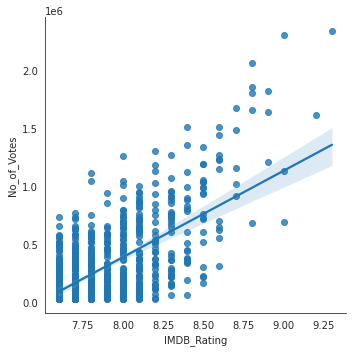

In [0]:
sns.set_style("white")
sns.lmplot(x='IMDB_Rating', y='No_of_Votes', data=df)

In [0]:
df_2= sdf.select('No_of_Votes','Meta_score').toPandas()


Out[18]: <seaborn.axisgrid.FacetGrid at 0x7fab245fccd0>

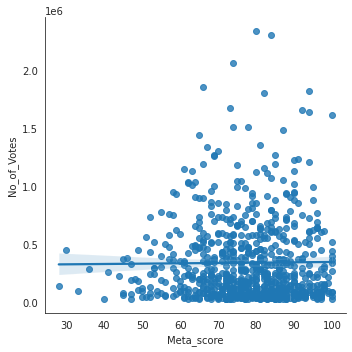

In [0]:
sns.set_style("white")
sns.lmplot(y='No_of_Votes', x='Meta_score', data=df_2)

In [0]:
df_3= sdf.select('IMDB_Rating','Meta_score').toPandas()


Out[20]: <seaborn.axisgrid.FacetGrid at 0x7fab24616a30>

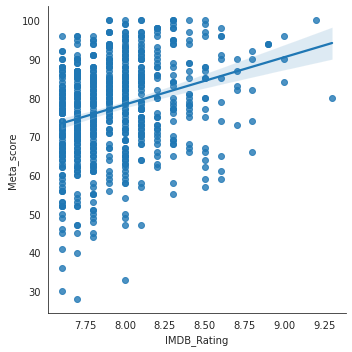

In [0]:
sns.set_style("white")
sns.lmplot(x='IMDB_Rating', y='Meta_score', data=df_3)

In [0]:
# Read in the Parquet file
s3_url = 's3a://my-bigdata-project-ec/Raw/cleaned_imdb_top_1000.parquet' 
sdf = spark.read.parquet(s3_url)

In [0]:
from pyspark.ml.feature import MinMaxScaler
# Scale the Age Vector from 0.0 to 1.0
scaler = MinMaxScaler(inputCol="IMDB_Rating", outputCol="Meta_score")

In [0]:
from pyspark.ml.feature import Binarizer
reviewScore_sdf =sdf[["Meta_score", "IMDB_Rating"]]
binarizer = Binarizer(threshold=90.0, inputCol="Meta_score", outputCol='binary_rating')
binarized_reviewScore_sdf = binarizer.transform(reviewScore_sdf)
print("Binarizer output with Threshold", binarizer.getThreshold())
binarized_reviewScore_sdf.show(20)

Binarizer output with Threshold 90.0
+----------+-----------+-------------+
|Meta_score|IMDB_Rating|binary_rating|
+----------+-----------+-------------+
|      80.0|        9.3|          0.0|
|     100.0|        9.2|          1.0|
|      84.0|        9.0|          0.0|
|      90.0|        9.0|          0.0|
|      96.0|        9.0|          1.0|
|      94.0|        8.9|          1.0|
|      94.0|        8.9|          1.0|
|      94.0|        8.9|          1.0|
|      74.0|        8.8|          0.0|
|      66.0|        8.8|          0.0|
|      92.0|        8.8|          1.0|
|      82.0|        8.8|          0.0|
|      90.0|        8.8|          0.0|
|      87.0|        8.7|          0.0|
|      73.0|        8.7|          0.0|
|      90.0|        8.7|          0.0|
|      82.0|        8.7|          0.0|
|      83.0|        8.7|          0.0|
|      96.0|        8.6|          1.0|
|      74.0|        8.6|          0.0|
+----------+-----------+-------------+
only showing top 20 rows



In [0]:
# Genre, Released_Year, Runtime, IMDB_Rating, Meta_score, No_of_Votes plus the text of the overview to predict the Gross
# Genre           Categorical Variable  use OneHotEncoder, Indexer
# Release_Year    Categorical Variable use OneHotEncoder, Indexer
# Runtime         Continuous but need to strip out the " min" from it.
# IMDB_Rating     Continuous   make sure no null values and Double data type
# Meta_score      Continuous   make sure no null values and Double data type
# No_of_Votes     Continuous   make sure no null values and Double data type
# Gross           Continuous   make sure no null values and Double data type